In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import scirdv1, scirdv1, Orbits, DefaultOrbits, LISAModel, EqualArmlengthOrbits
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform
from lisatools.stochastic import StochasticContribution, StochasticContributionContainer

import os
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.


## Define Stochastic Contributions

In [4]:
# Define a frequency axis
f = np.logspace(-4, 0, 1000)

In [5]:
def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


In [6]:
# for stoch in ["GWB_LISA_HS", "GWB_LISA_LS"]:
#     psd_kwargs = dict(
#         stochastic_function=Space2050GWB,
#         stochastic_params=(stochastic_contributions[stoch],),
#     )
#     missions["lisa_" + stoch] = dict(
#         model=lisa,
#         psd_kwargs=psd_kwargs,
#         Tobs=YRSID_SI, 
#         dt=10.0
#     )

### With and without stochastic contribution

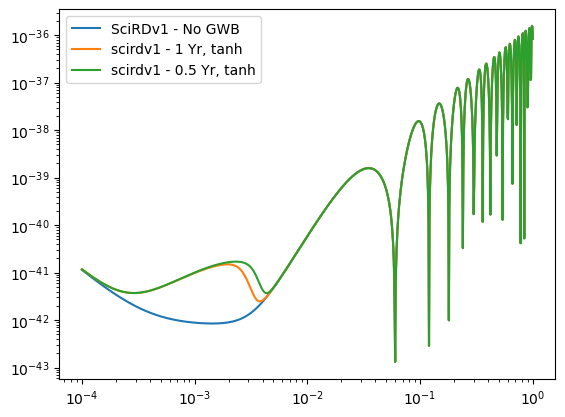

In [8]:
fn = f.copy()
Sn_no_GWB_srd = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB_srd, c=f"C0", label="SciRDv1 - No GWB")
Sn_with_GWB_1yr = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, stochastic_params=(YRSID_SI,))
plt.loglog(fn, Sn_with_GWB_1yr, c=f"C1", label="scirdv1 - 1 Yr, tanh")
Sn_with_GWB_05yr = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, stochastic_params=(0.5 * YRSID_SI,))
plt.loglog(fn, Sn_with_GWB_05yr, c=f"C2", label="scirdv1 - 0.5 Yr, tanh")
plt.legend()
plt.savefig("sensitivity_and_foreground.png")

## Diagnostics

Setup all snr calculators

In [6]:
calculators = {}
orbits_here = EqualArmlengthOrbits()
Tobs = 1.0 * YRSID_SI
dt = 10.0

psd_kwargs = dict(
    stochastic_params=(Tobs,),
)

# black hole generator
bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=False))

calculators["bbh"] = BBHCalculationController(
    bbh, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# gb generator
gb = GBAETWaveform(orbits=orbits_here)

calculators["gb"] = GBCalculationController(
    gb, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# emri generator
emri = EMRITDIWaveform(
    T=Tobs / YRSID_SI, 
    dt=dt, 
    response_kwargs=dict(tdi="1st generation", orbits=orbits_here)
)

calculators["emri"] = EMRICalculationController(
    emri, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)
    


Data file SchwarzschildEccentricInput.hdf5 not found. Downloading now.


Output()

Data file AmplitudeVectorNorm.dat not found. Downloading now.


Output()

### MBHBs

1416.021645635503


Text(0, 0.5, 'Char strain')

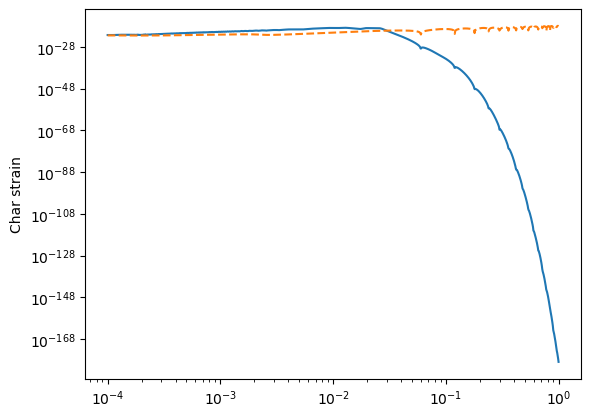

In [67]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

print(calculators["bbh"].get_snr(*mbh_injection_params, freqs=np.logspace(-4, 0, 1024)))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["bbh"].f_arr, calculators["bbh"].f_arr * np.abs(calculators["bbh"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [31]:

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 5e6
m2 = 5e6
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

from eryn.prior import uniform_dist, ProbDistContainer
from eryn.utils import TransformContainer

 # priors
priors_mbh = ProbDistContainer({
    0: uniform_dist(np.log(1e4), np.log(1e8)),
    1: uniform_dist(0.1, 0.999999999),
    2: uniform_dist(-0.99999999, +0.99999999),
    3: uniform_dist(-0.99999999, +0.99999999),
    4: uniform_dist(0.01, 1000.0),
    5: uniform_dist(0.0, 2 * np.pi),
    6: uniform_dist(-1.0 + 1e-6, 1.0 - 1e-6),
    7: uniform_dist(0.0, 2 * np.pi),
    8: uniform_dist(-1.0 + 1e-6, 1.0 - 1e-6),
    9: uniform_dist(0.0, np.pi),
    10: uniform_dist(0.0, Tobs + 3600.0),
})

 # for transforms
fill_dict_mbh = {
    "ndim_full": 12,
    "fill_values": np.array([0.0]),
    "fill_inds": np.array([6]),
}

# transforms from pe to waveform generation
parameter_transforms_mbh = {
    0: np.exp,
    4: lambda x: x * 1e9 * PC_SI,
    7: np.arccos,
    9: np.arcsin,
    (0, 1): lambda mT, q: (mT / (1 + q), mT * q / (1 + q))
}

transform_fn_mbh = TransformContainer(
    parameter_transforms=parameter_transforms_mbh,
    fill_dict=fill_dict_mbh,
)



z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc


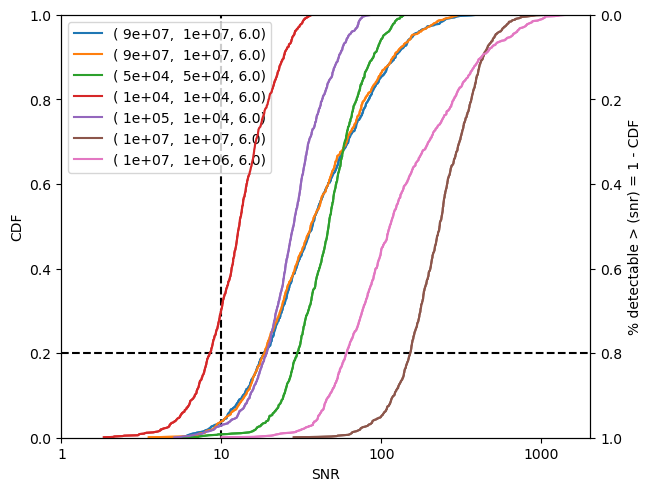

In [70]:
from astropy.cosmology import Planck15
from astropy import units as u

draws = 1024
snr_lim = 10.0
requirement = 0.8

plt.close()
fig, ax = plt.subplots(layout='constrained')
ax.axvline(np.log10(snr_lim), color="k", ls="--")
ax.axhline(1 - 0.8, color="k", ls="--")
ax2 = ax.twinx()

injs = [(9e7, 1e7, 6.0), (9e7, 1e7, 6.0), (5e4, 5e4, 6.0), (1e4, 1e4, 6.0), (1e5, 1e4, 6.0), (1e7, 1e7, 6.0), (1e7, 1e6, 6.0)]
for i, (m1, m2, z) in enumerate(injs):
    new_systems = transform_fn_mbh.both_transforms(priors_mbh.rvs(size=draws))

    new_systems[:, 0] = m1
    new_systems[:, 1] = m2
    dL = Planck15.luminosity_distance(z).to(u.m).value
    print(f"z: {z}, dL: {Planck15.luminosity_distance(z).to(u.Gpc)}")
    new_systems[:, 4] = dL
    
    snrs_out = np.zeros(draws)
    for j in range(draws):
        snrs_out[j] = calculators["bbh"].get_snr(*new_systems[j], freqs=np.logspace(-4, 0, 1024))
    
    log10_snrs_out = np.log10(snrs_out.copy())

    cdf = np.arange(1, log10_snrs_out.shape[0] + 1) / log10_snrs_out.shape[0]
    det_frac = 1 - cdf
    x = np.sort(snrs_out)
        
    ax.plot(np.log10(x), cdf, color=f"C{i}", label=f"({m1: .0e}, {m2: .0e}, {z})")
    ax2.plot(np.log10(x), det_frac, color=f"C{i}", label=f"{(m1, m2, z)}")
    
ax2.set_ylim(1.0, 0.0)
ax.set_ylim(0.0, 1.0)
ax2.set_ylabel('% detectable > (snr) = 1 - CDF')
ax.set_xlabel("SNR")
ax.set_xticks(np.log10([1, 10, 100, 1000]))
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel("CDF")
ax.legend()
#fig.savefig("mbh_fom_like_plot.png")

In [13]:
snrs_out

array([173.2130351 ,  64.57552973, 968.79871586, ..., 401.47022088,
       174.7230332 , 296.3723985 ])

In [ ]:
# example with last mission
scaled_inj_params, cov = calculators["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


In [ ]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

In [ ]:
%%timeit

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

print(calculators["bbh"].get_snr(*mbh_injection_params))

### GBs

In [ ]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])

print(calculators["gb"].get_snr(*gb_injection_params))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["gb"].f_arr, calculators["gb"].f_arr * np.abs(calculators["gb"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [ ]:
scaled_inj_params, cov = calculators["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

In [ ]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [ ]:
vgbs = pd.read_csv("vgbs.txt")

In [ ]:
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
df = get_df(Tobs, dt)
plt.loglog(fn, Sn ** (1/2), c=f"k", ls="--")
for j in range(len(vgbs)):
    vgb = vgbs.iloc[j]
    params_in = np.array([
        vgb["Amplitude"],
        vgb["Frequency"],
        vgb["FrequencyDerivative"],
        0.0,
        vgb["InitialPhase"],
        vgb["Inclination"],
        vgb["Polarization"],
        vgb["EclipticLongitude"],
        vgb["EclipticLatitude"]
    ])
    print(vgb["Name"], calculators["gb"].get_snr(*params_in, tdi2=True))
    plt.loglog(calculators["gb"].f_arr, np.abs(calculators["gb"].last_output[0]), c=f"C{j}")

### EMRIs

In [10]:
from few.trajectory.inspiral import EMRIInspiral

22.170781335744696


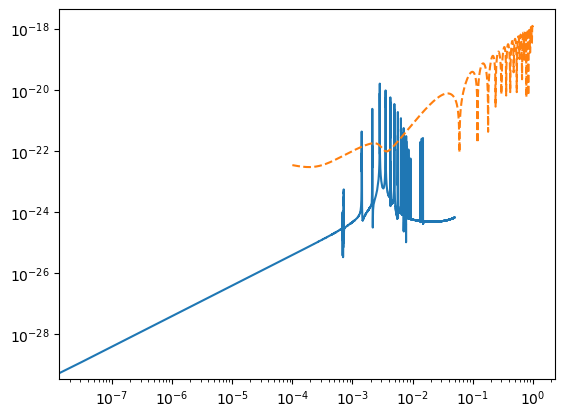

In [12]:
M = 1e6
mu = 0.1
a = 0.7
p0 = 8.0
e0 = 0.1
x0 = 0.1
dist = 0.084
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

print(calculators["emri"].get_snr(*emri_injection_params))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
emri_freqs = np.fft.rfftfreq(calculators["emri"].last_output[0].shape[0], calculators["emri"].aet_template_gen.dt)
plt.loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(calculators["emri"].last_output[0])) * calculators["emri"].aet_template_gen.dt, c=f"C0")
plt.loglog(fn, np.sqrt(fn) * (Sn) ** (1/2), c=f"C1", ls="--")


In [14]:
M = 1e6
mu = 0.1
a = 0.6
p0 = 12.0
e0 = 0.2
x0 = 0.1
dist = 0.084
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

from eryn.prior import uniform_dist, ProbDistContainer
from eryn.utils import TransformContainer

# priors
priors_emri = ProbDistContainer({
    0: uniform_dist(np.log(1e5), np.log(1e6)),
    1: uniform_dist(10.0, 50.0),
    2: uniform_dist(0.0001, +0.9),
    3: uniform_dist(6.5, 9.0),
    4: uniform_dist(0.01, 0.3),
    5: uniform_dist(-0.99, 0.99),
    6: uniform_dist(0.01, 10.0),
    7: uniform_dist(-0.99, 0.99),
    8: uniform_dist(0.0, 2 * np.pi),
    9: uniform_dist(-0.99, 0.99),
    10: uniform_dist(0.0, 2 * np.pi),
    11: uniform_dist(0.0, 2 * np.pi),
    12: uniform_dist(0.0, 2 * np.pi),
    13: uniform_dist(0.0, 2 * np.pi), 
})

 # for transforms
fill_dict_emri = None

# transforms from pe to waveform generation
parameter_transforms_emri = {
    0: np.exp,
    7: np.arccos,
    9: np.arccos,
}

transform_fn_emri = TransformContainer(
    parameter_transforms=parameter_transforms_emri,
    fill_dict=fill_dict_emri,
)



0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31


/var/folders/48/f81xrxy94d7_ygl8wwthcwlw0000gp/T/ipykernel_71007/1387866441.py:38: RuntimeWarning: divide by zero encountered in log10
  log10_snrs_out = np.log10(snrs_here)
/var/folders/48/f81xrxy94d7_ygl8wwthcwlw0000gp/T/ipykernel_71007/1387866441.py:44: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(x), cdf, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
/var/folders/48/f81xrxy94d7_ygl8wwthcwlw0000gp/T/ipykernel_71007/1387866441.py:45: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(x), det_frac, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")


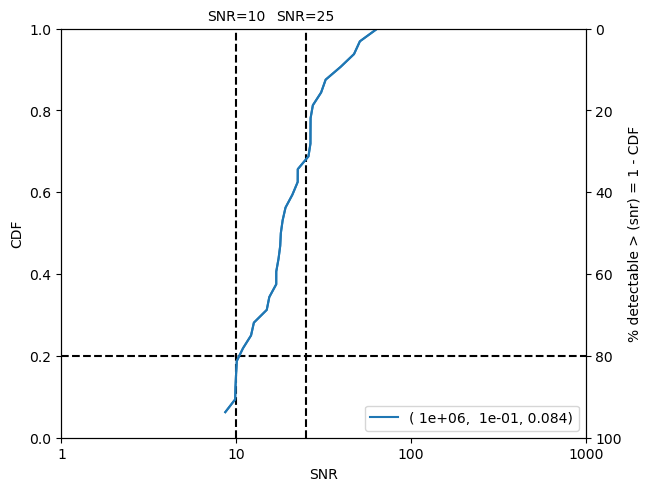

In [15]:
draws = 32
snr_lim = 25.0
requirement = 0.8

masses = [(1e6, 0.1)]  # (1e7, 10.0), (1e6, 10.0), (1e5, 10.0), (5e5, 10.0), (5e6, 10.0), (3e5, 10.0)]
dL = 1.0
for i, (M, mu) in enumerate(masses):
    new_systems = transform_fn_emri.both_transforms(priors_emri.rvs(size=draws))

    new_systems[:, 0] = M
    new_systems[:, 1] = mu
    # dL = Planck15.luminosity_distance(z).to(u.Gpc).value
    # print(f"z: {z}, dL: {Planck15.luminosity_distance(z).to(u.Gpc)}")
    
    new_systems[:, 6] = dL

    new_systems[:, 2] = 0.0
    new_systems[:, 5] = 1.0

    snrs_out = np.zeros(draws)
    for j in range(draws):
        snrs_out[j] = calculators["emri"].get_snr(*new_systems[j])
        print(i, j)
    
    plt.close()
    fig, ax = plt.subplots(layout='constrained')
    ax.axvline(np.log10(snr_lim), color="k", ls="--")
    ax.text(np.log10(snr_lim), 1.02, "SNR=25", ha="center")
    
    ax.axvline(np.log10(10.0), color="k", ls="--")
    ax.text(np.log10(10.0), 1.02, "SNR=10", ha="center")
    
    ax.axhline(1 - 0.8, color="k", ls="--")
    ax2 = ax.twinx() 
    lss = ["solid", "dashed"]
    for jj, dL_tmp in enumerate([0.084]):
        snrs_here = snrs_out.copy() * (dL / dL_tmp)
        log10_snrs_out = np.log10(snrs_here)
    
        cdf = np.arange(1, log10_snrs_out.shape[0] + 1) / log10_snrs_out.shape[0]
        det_frac = (1 - cdf) * 100
        x = np.sort(snrs_here)
            
        ax.plot(np.log10(x), cdf, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
        ax2.plot(np.log10(x), det_frac, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
            
    ax2.set_ylim(100.0, 0.0)
    ax.set_ylim(0.0, 1.0)
    ax2.set_ylabel('% detectable > (snr) = 1 - CDF')
    ax.set_xlabel("SNR")
    ax.set_xticks(np.log10([1, 10, 100, 1000]))
    ax.set_xticklabels([1, 10, 100, 1000])
    ax.set_ylabel("CDF")
    ax.legend()
    #fig.savefig(f"emris_{M:.0e}_{mu:.0e}_detectability_check_prior_down_to_p0_8M.png")
            
       

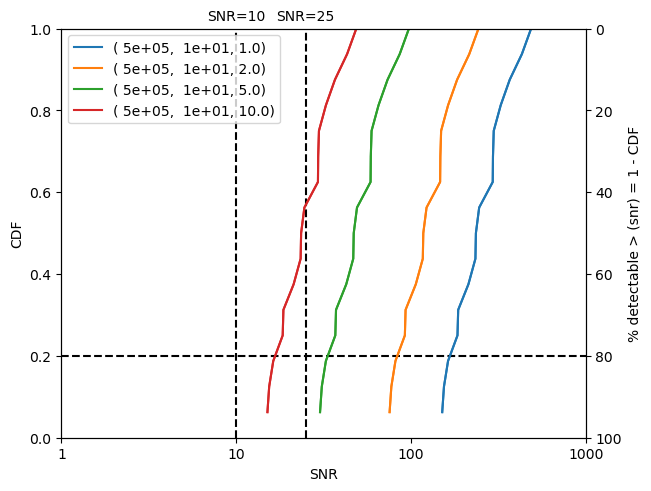

In [60]:
plt.close()
fig, ax = plt.subplots(layout='constrained')
ax.axvline(np.log10(snr_lim), color="k", ls="--")
ax.text(np.log10(snr_lim), 1.02, "SNR=25", ha="center")

ax.axvline(np.log10(10.0), color="k", ls="--")
ax.text(np.log10(10.0), 1.02, "SNR=10", ha="center")

ax.axhline(1 - 0.8, color="k", ls="--")
ax2 = ax.twinx() 
lss = ["solid", "dashed"]
for jj, dL_tmp in enumerate([1.0, 2.0, 5.0, 10.0]):
    snrs_here = snrs_out.copy() * (dL / dL_tmp)
    log10_snrs_out = np.log10(snrs_here)

    cdf = np.arange(1, log10_snrs_out.shape[0] + 1) / log10_snrs_out.shape[0]
    det_frac = (1 - cdf) * 100
    x = np.sort(snrs_here)
        
    ax.plot(np.log10(x), cdf, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
    ax2.plot(np.log10(x), det_frac, color=f"C{jj}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
        
ax2.set_ylim(100.0, 0.0)
ax.set_ylim(0.0, 1.0)
ax2.set_ylabel('% detectable > (snr) = 1 - CDF')
ax.set_xlabel("SNR")
ax.set_xticks(np.log10([1, 10, 100, 1000]))
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel("CDF")
ax.legend()
fig.savefig(f"emris_{M:.0e}_{mu:.0e}_detectability_check.png")

## 